# Netrisk lakásbiztosítási adatelemzés

## Feladatleírás

Ez a munkafüzet a Netrisk lakásbiztosítási kampányának elemzésére készült, az alábbi kérdésekre ad választ:

1. Készítsd elő a táblát elemzésre, ha szükséges. Amennyiben úgy gondolod
külső, publikus adatot is köthetsz hozzá.

2. Röviden mutasd be, hogy hányan rendelkeznek eddig lakásbiztosítással és mi
jellemző rájuk.

3. Készíts egy prediktív modellt (pl. logisztikus regresszió, döntési fa vagy
XGBoost), ami előrejelzi, hogy egy ügyfél vásárolni fog-e (conversion=1) a
következő kampány során. Röviden magyarázd el, milyen változók bizonyultak
legfontosabbnak.

4. Milyen 3 konkrét javaslatot fogalmaznál meg a marketing csapatnak az
eredmények alapján. Hogyan használnád fel a kommunikációban?

## Megoldás menete

A megoldások a feladatrésznként röviden az alábbiak szerint fognak alakulni:

1. feladat
- A táblázatot tisztítani szükséges volt, az ügyfelek közül 30%-hoz nem rendelkeztünk autó típus és életkor adattal, ugyanakkor a hiányzó adatok pótlását nem MICE algoritmussal, hanem label-ezéssel oldottam meg, mivel feltételeztem, hogy *az adathiány strukturális okhoz köthető*.
- Minden ügyfélnek rendelkezünk irányítószámmal, ez ugyanakkor mintaadat lévén sajnos nem minden esetben valós magyar irányítószám. Emiatt csak a megyei adathoz tudtam a háztípusának megfelelő átlagárat kötni, amely a KSH Ingatlanadattárából származik ([LINK](https://www.ksh.hu/s/ingatlanadattar/)). Az adatok irányítószám szinten is rendelkezésre álltak volna.
- A marketing funkciókhoz közelebb álló csoportokat alkottam bizonyos oszlopokból. Az életkorból 10 éves target groupokat képeztem, míg a regisztráció időpontját a mai dátummal alakítottam át eltelt napok számára

2. feladat

A lakásbiztosítással rendelkező ügyfeleket két változó alapján is meg lehet fogni, azonban a kérdés általam értelmezve a b) opcióra kérdez rá.
- a) `current_home` – Jelenleg lakásbiztosítással rendelkezik
- b) `home_purchased_last_12m` – Vásárolt lakásbiztosítást az elmúlt 12 hónapban

A jelenleg lakásbiztosítással rendelkező ügyfeleket el tudjuk különíteni a megadott változók nyomán, ugyanakkor egy log-odds rátát használva láthatjuk azt is, hogy melyik numerikus vagy kategorikus változó az, amelyik a legnagyobb különbséget jelenti a két csoport között. Ezek azok a jellemzők, amelyek leginkább elkülönítik a jelenlegi vásárlókat. Ellenőrzésképpen egy ugyanilyen elemzést készítettem a másik b) pontban meghatározott változóra is.

3. feladat

XGBoost modellt készítettem, amely a fenti b) `home_purchased_last_12m` változót vette figyelembe, mint célváltozó, hiszen feltételeztem, hogy az *előző kampány miatt kerültek be jelenleg lakásvásárlással rendlekező ügyfelek a rendszerbe*.
A modell hiperparamétereinek optimalizálására Optuna csomagot használtam, így a modell kimenetét és az előrejelzést a legkevésbé befolyásolják a kezdeti értékek. Végül SHAP módszerekkel elemeztem az XGBoost eredményeit, így a fekete doboz-szerű modellből effektív, lefordítható ábrákon tudtam a konklúziókat levonni a legfontosabb változók, és így a marketing célcsoport felé.

4. feladat

A kommunikációs üzenetek kialakításában a fenti 3 lépésben kialakított profilok segítettek.


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import plotly.express as px
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, average_precision_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import optuna
import shap
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler
import pickle
import os


plt.style.use('default')

ref_date = pd.Timestamp.today()

netrisk_colors = {
    'first': '#ff7900', 
    'second': '#6e6ee5',
    'third': '#f5f5f5'
}

# Create output directories
output_dir = Path("../outputs/figures")
output_dir.mkdir(parents=True, exist_ok=True)

def save_plot(fig, name, dpi=300):
    """Save plot as both PNG image and pickle object"""
    # Save as PNG
    fig.savefig(output_dir / f"{name}.png", dpi=dpi, bbox_inches='tight')
    # Save as pickle object for reuse
    print(f"Plot saved: {name}.png")

netrisk_cycle = cycler(color=[
    netrisk_colors['first'], netrisk_colors['second'], netrisk_colors['third'],
    '#ff9500', '#8a8aff', '#d9d9d9'
])
plt.rc('axes', prop_cycle=netrisk_cycle)


In [2]:
netrisk_dataset_raw = pd.read_csv("../data/raw/netrisk_dataset.csv")
netrisk_dataset_raw.head()

,customer_id,birth_date,gender,zip_code,registration_date,current_mtpl,current_casco,current_travel,current_home,mtpl_purchased_last_12m,...,car_age_years,home_size_sqm,home_type,home_built_year,contracts_count,engagement_propensity,last_login_days_ago,email_open_rate,active_last_90d,county_name
0,1,10/9/1986,Nő,6170,9/17/2019,1,0,0,0,0,...,15.0,139,családi ház,1968,1,0.7583,358,0.2522,0,Bács-Kiskun
1,2,10/9/1987,Nő,3810,6/23/2015,1,0,0,0,0,...,NaN,103,társasház,1985,1,0.6527,141,0.1930,0,Borsod-Abaúj-Zemplén
2,3,10/9/1983,Nő,8345,9/25/2003,1,0,0,1,1,...,10.0,109,családi ház,2019,2,0.4304,342,0.2103,0,Veszprém
3,4,10/9/1999,Nő,5346,11/2/2017,1,0,0,0,0,...,14.0,35,panel,1960,1,0.6086,265,0.1622,0,Jász-Nagykun-Szolnok
4,5,10/8/1988,Nő,4139,9/12/2015,1,0,0,0,1,...,11.0,47,panel,1961,1,0.6496,291,0.2732,0,Hajdú-Bihar


## Feature engineering

- Dátumok tisztítása
- Évek kiszámítása képzett oszlopokkal
- Autó tulajdonlás oszlopa a kötött biztosítások alapján (feltételezve, hogy az ügyfél a saját autójára kötötte a Casco-t vagy KGFB-t)
- Évek kategorikussá alakítása
- Lakásár becslés hozzáadása


In [3]:
# Parse dates (MDY); if they are already parsed, this will just coerce again harmlessly
netrisk_dataset_raw['birth_date'] = pd.to_datetime(netrisk_dataset_raw['birth_date'], format='%m/%d/%Y', errors='coerce')
netrisk_dataset_raw['registration_date'] = pd.to_datetime(netrisk_dataset_raw['registration_date'], format='%m/%d/%Y', errors='coerce')

# Age and tenure
netrisk_dataset_raw['age_years'] = (ref_date - netrisk_dataset_raw['birth_date']).dt.days / 365.25
netrisk_dataset_raw['tenure_years'] = (ref_date - netrisk_dataset_raw['registration_date']).dt.days / 365.25

# Age groups (target marketing segments)
netrisk_dataset_raw['age_group'] = pd.cut(
    netrisk_dataset_raw['age_years'],
    bins=[0, 20, 30, 40, 50, 60, 70, 80, np.inf],
    labels=['00-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'],
    right=False
)

# Home age
netrisk_dataset_raw['home_age_years'] = np.where(
    netrisk_dataset_raw['home_built_year'].notna(),
    ref_date.year - netrisk_dataset_raw['home_built_year'],
    np.nan
)

# Car make handling - "Other" if MTPL or Casco is 1 but make is missing, otherwise "No data"
netrisk_dataset_raw['car_make'] = netrisk_dataset_raw['car_make'].replace('', np.nan)
netrisk_dataset_raw['car_make'] = np.where(
    netrisk_dataset_raw['car_make'].isna() & 
    ((netrisk_dataset_raw['current_mtpl'] == 1) | (netrisk_dataset_raw['mtpl_purchased_last_12m'] == 1) | (netrisk_dataset_raw['casco_purchased_last_12m'] == 1) | (netrisk_dataset_raw['current_casco'] == 1)),
    "Other",
    np.where(netrisk_dataset_raw['car_make'].isna(), "No data", netrisk_dataset_raw['car_make'])
)

# Has car - "Yes" if car make is known/Other, "No data" if truly missing
netrisk_dataset_raw['has_car'] = np.where(
    netrisk_dataset_raw['car_make'].isin(["No data"]),
    "No data",
    "Yes"
)

# Zip as category-like
netrisk_dataset_raw['zip_code'] = netrisk_dataset_raw['zip_code'].astype(str)
netrisk_dataset_raw[['age_years', 'age_group', 'tenure_years','home_age_years','car_make','has_car']].head()

,age_years,age_group,tenure_years,home_age_years,car_make,has_car
0,39.134839,30-39,6.195756,57.0,Opel,Yes
1,38.135524,30-39,10.431211,40.0,Other,Yes
2,42.135524,40-49,22.173854,6.0,Ford,Yes
3,26.135524,20-29,8.068446,65.0,Suzuki,Yes
4,37.136208,30-39,10.209446,64.0,Nissan,Yes


In [4]:
# -------------------------------------------------------------------
# Dictionary equivalent
# -------------------------------------------------------------------
dictionary = {
    "családi_ház": "családi ház",
    "lakótelepi_panel": "panel",
    "többlakásos_társasház": "társasház",
}

def clean_names(df):
    """Convert column names to snake_case"""
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace(r'[^\w]', '', regex=True)
    return df

# -------------------------------------------------------------------
# county_price_table
# -------------------------------------------------------------------

file_path = "../data/raw/county_prices/Ingatlanadattár, 2024.csv"

# Load and concatenate all files
county_price_table = clean_names(pd.read_csv(file_path, sep=";", decimal=","))

county_price_table = (
    county_price_table
    .rename(columns={"az_ingatlan_helye": "county_name"})
    .loc[:, lambda df: ["county_name"] + [c for c in df.columns if "átlagár_ezer" in c]]
    .melt(id_vars="county_name", var_name="home_type", value_name="avg_sqm_price")
 )

county_price_table["home_type"] = (
    county_price_table["home_type"]
    .str.replace("_átlagár_ezer_.*", "", regex=True)
    .replace(dictionary)                               
)

county_price_table = county_price_table[
    (county_price_table["home_type"] != "lakások_összesen")
    & county_price_table["avg_sqm_price"].notna()
    & county_price_table["county_name"].str.contains("Budapest$|vármegye", regex=True, na=False)
]

county_price_table["county_name"] = (
    county_price_table["county_name"]
    .str.replace("összesen|vármegye", "", regex=True)  
    .str.replace(r"\s+", " ", regex=True)              
    .str.strip()
)

netrisk_dataset_clean = netrisk_dataset_raw.merge(county_price_table, how="left")


## Csoportok kialakítása

A kiválasztott célváltozók felbontásában a kategorikus szintek és a numerikus változókra is megvizsgálom, hogy melyik mutatja a legnagyobb eltérést, tehát miben különböznek a leginkább az adatbázisban szereplő lakásbiztosítást vásárló és nem vásárló ügyfelek.
Minden változóra a log-odds számítást alkalmazom, ezzel összehasonlítható a két típusú változó.

Plot saved: 01_log_odds_comparison.png


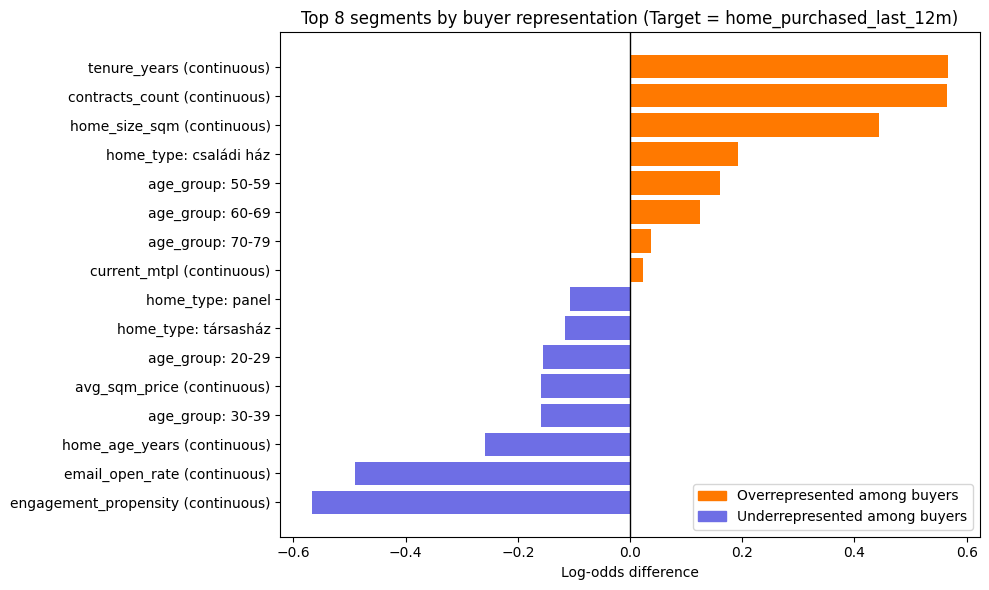

In [5]:
def log_odds_per_category(df, cat_col, target_col, alpha=1e-6, min_total_count=50):
    tab_counts = pd.crosstab(df[cat_col], df[target_col])
    if not set([0, 1]).issubset(tab_counts.columns):
        return pd.DataFrame()

    total = tab_counts[0] + tab_counts[1]
    mask = total >= min_total_count
    tab_counts = tab_counts[mask]

    if tab_counts.empty:
        return pd.DataFrame()

    tab_probs = pd.crosstab(df[cat_col], df[target_col], normalize="columns").loc[tab_counts.index]
    p1 = tab_probs[1]
    p0 = tab_probs[0]
    lor = np.log((p1 + alpha) / (p0 + alpha))

    out = pd.DataFrame({
        "variable": cat_col,
        "category_value": lor.index.astype(str),
        "log_odds": lor.values,
        "count_buyer": tab_counts[1].values,
        "count_nonbuyer": tab_counts[0].values,
    })

    out["total_count"] = out["count_buyer"] + out["count_nonbuyer"]
    out["abs_log_odds"] = out["log_odds"].abs()
    out["type"] = "categorical_value"
    out = out.sort_values("abs_log_odds", ascending=False)
    return out

def numeric_log_odds(df, num_col, target_col):
    x = df[[num_col]].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
    if x.empty:
        return None

    y = df.loc[x.index, target_col].astype(int)
    std = x[num_col].std()
    if std == 0 or np.isnan(std):
        return None

    lr = LogisticRegression(max_iter=2000)
    lr.fit(x, y)

    beta = lr.coef_[0][0]
    standardized_log_odds = beta * std

    out = pd.DataFrame({
        "variable": [num_col],
        "category_value": [f"{num_col} (continuous)"],
        "log_odds": [standardized_log_odds],
    })
    out["abs_log_odds"] = out["log_odds"].abs()
    out["type"] = "numeric_continuous"
    return out

def unified_value_level_diff(df, target_col, numeric_cols, categorical_cols, alpha=0.5, min_total_count=50):
    results = []

    for col in categorical_cols:
        if col not in df.columns:
            continue
        tmp = log_odds_per_category(df=df, cat_col=col, target_col=target_col, alpha=alpha, min_total_count=min_total_count)
        if tmp is not None and not tmp.empty:
            results.append(tmp)

    for col in numeric_cols:
        if col not in df.columns:
            continue
        tmp = numeric_log_odds(df=df, num_col=col, target_col=target_col)
        if tmp is not None:
            results.append(tmp)

    if not results:
        return pd.DataFrame()

    all_df = pd.concat(results, ignore_index=True)
    all_df = all_df.sort_values("abs_log_odds", ascending=False)
    return all_df

# Analysis
TARGET = "home_purchased_last_12m"

# Adjustable which columns to include
numeric_cols = ['car_age_years', 'home_size_sqm', 'engagement_propensity', 'last_login_days_ago', 'email_open_rate', 'tenure_years', 'home_age_years', 'avg_sqm_price', 'contracts_count', 'current_mtpl', 'current_casco', 'current_travel', 'mtpl_purchased_last_12m', 'casco_purchased_last_12m', 'travel_purchased_last_12m', 'active_last_90d']
categorical_cols = ['gender', 'car_make', 'home_type', 'county_name', 'age_group', 'has_car']

unified = unified_value_level_diff(
    df=netrisk_dataset_clean, target_col=TARGET, numeric_cols=numeric_cols, 
    categorical_cols=categorical_cols, alpha=0.5, min_total_count=100
)

# Plot top effects
TOP_N = 8
pos = unified[unified["log_odds"] > 0].nlargest(TOP_N, "log_odds")
neg = unified[unified["log_odds"] < 0].nsmallest(TOP_N, "log_odds")
both = pd.concat([neg, pos], ignore_index=True)


# Create display labels showing column name before categorical values
both["display_label"] = both.apply(lambda row: 
    f"{row['variable']}: {row['category_value']}" if row['type'] == 'categorical_value' 
    else row['category_value'], axis=1)

both["sign"] = np.where(both["log_odds"] > 0, "positive", "negative")
both = both.sort_values("log_odds")

color_map = {"positive": netrisk_colors['first'], "negative": netrisk_colors['second']}
colors = both["sign"].map(color_map)

fig = plt.figure(figsize=(10, max(6, len(both) * 0.3)))
plt.barh(both["display_label"], both["log_odds"], color=colors)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Log-odds difference")
plt.title(f"Top {TOP_N} segments by buyer representation (Target = {TARGET})")

legend_handles = [
    Patch(color=color_map["positive"], label="Overrepresented among buyers"),
    Patch(color=color_map["negative"], label="Underrepresented among buyers")
]
plt.legend(handles=legend_handles, loc="lower right")
plt.tight_layout()
save_plot(fig, "01_log_odds_comparison")

## Predikciós modell tanítása (XGBoost)

A felhasznált kategorikus paramétereket kétféle módszerrel is felhasználhatjuk, a klasszikus, szintekre fókuszáló one-hot encodinggal vagy a numerikussá alakító, információs tartalomra fókuszáló log-odds módszertannal. Ezek után a kiválasztott feature-öket egy baseline modellen kipróbálom.

In [6]:
def target_encode_log_odds(df, col, target, alpha=0.5):
    tab = pd.crosstab(df[col], df[target])
    if 0 not in tab.columns or 1 not in tab.columns:
        return df[col].value_counts(normalize=True)

    n1 = tab[1] + alpha
    n0 = tab[0] + alpha
    lor = np.log(n1 / n0)
    return lor

def apply_log_odds_encoding(train_df, test_df, col, target):
    enc = target_encode_log_odds(train_df, col, target)
    train_encoded = train_df[col].map(enc).fillna(0)
    test_encoded = test_df[col].map(enc).fillna(0)
    return train_encoded, test_encoded

def apply_one_hot_encoding(train_df, test_df, categorical_cols, max_categories=50):
    """Apply one-hot encoding to categorical variables"""
    import pandas as pd
    
    # Get all unique categories from training set
    train_features = []
    test_features = []
    feature_names = []
    
    for col in categorical_cols:
        if col not in train_df.columns:
            continue
            
        # Get top categories from training set to avoid too many features
        top_categories = train_df[col].value_counts().head(max_categories).index.tolist()
        
        # Remove "No data" levels from encoding
        top_categories = [cat for cat in top_categories if cat != "No data"]
        
        # Create one-hot encoded features
        for category in top_categories:
            feature_name = f"{col}_{category}"
            train_feature = (train_df[col] == category).astype(int)
            test_feature = (test_df[col] == category).astype(int)
            
            train_features.append(train_feature)
            test_features.append(test_feature)
            feature_names.append(feature_name)
    
    # Combine into DataFrames
    train_encoded = pd.concat(train_features, axis=1, keys=feature_names)
    test_encoded = pd.concat(test_features, axis=1, keys=feature_names)
    
    return train_encoded, test_encoded


ENCODING_METHOD = "onehot"  # Change to "lor" for log-odds ratio and "onehot" for one-hot encoding
FEATURES_CATEG = categorical_cols
FEATURES_NUM = numeric_cols

train_df, test_df = train_test_split(netrisk_dataset_clean, 
                                     test_size=0.2, 
                                     stratify=netrisk_dataset_clean[TARGET], 
                                     random_state=42)

# Apply chosen encoding method
if ENCODING_METHOD == "lor":
    
    # Encode categorical features with LOR
    for col in FEATURES_CATEG:
        train_df[col + "_lor"], test_df[col + "_lor"] = apply_log_odds_encoding(
            train_df, test_df, col, target=TARGET
        )
    
    FINAL_FEATURES = FEATURES_NUM + [c + "_lor" for c in FEATURES_CATEG]
    
elif ENCODING_METHOD == "onehot":
    
    # Apply one-hot encoding
    train_encoded, test_encoded = apply_one_hot_encoding(
        train_df, test_df, FEATURES_CATEG, max_categories=20
    )
    
    # Combine numeric and encoded categorical features
    train_numeric = train_df[FEATURES_NUM]
    test_numeric = test_df[FEATURES_NUM]
    
    # Reset indices to ensure proper concatenation
    train_encoded.index = train_numeric.index
    test_encoded.index = test_numeric.index
    
    train_combined = pd.concat([train_numeric, train_encoded], axis=1)
    test_combined = pd.concat([test_numeric, test_encoded], axis=1)
    
    FINAL_FEATURES = train_combined.columns.tolist()
    
    # Update dataframes
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    for col in train_combined.columns:
        train_df[col] = train_combined[col]
        test_df[col] = test_combined[col]

else:
    raise ValueError("ENCODING_METHOD must be 'lor' or 'onehot'")

X_train = train_df[FINAL_FEATURES]
y_train = train_df[TARGET]
X_test  = test_df[FINAL_FEATURES]
y_test  = test_df[TARGET]

# Train XGBoost
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

model = xgb.XGBClassifier(
    n_estimators=600, learning_rate=0.03, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=5,
    objective="binary:logistic", reg_lambda=1.0,
    scale_pos_weight=ratio, eval_metric="logloss",
    random_state=42, tree_method="hist"
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Calibrate
cal_model = CalibratedClassifierCV(model, cv="prefit", method="sigmoid")
cal_model.fit(X_test, y_test)

# Evaluate
pred_test = cal_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, pred_test)
avg_prec = average_precision_score(y_test, pred_test)

print(f"\nMODEL PERFORMANCE ({ENCODING_METHOD.upper()}):")
print(f"AUC: {auc:.3f}")
print(f"Average Precision: {avg_prec:.3f}")

# Score prospects
prospects = netrisk_dataset_clean[netrisk_dataset_clean[TARGET] == 0].copy()

if ENCODING_METHOD == "lor":
    for col in FEATURES_CATEG:
        enc = target_encode_log_odds(train_df, col, TARGET)
        prospects[col + "_lor"] = prospects[col].map(enc).fillna(0)
        
elif ENCODING_METHOD == "onehot":
    # Apply same one-hot encoding to prospects
    for col in FEATURES_CATEG:
        if col not in train_df.columns:
            continue
        # Get categories from training set (excluding "No data")
        top_categories = train_df[col].value_counts().head(20).index.tolist()
        top_categories = [cat for cat in top_categories if cat != "No data"]
        for category in top_categories:
            feature_name = f"{col}_{category}"
            prospects[feature_name] = (prospects[col] == category).astype(int)

prospects["score"] = cal_model.predict_proba(prospects[FINAL_FEATURES])[:, 1]
prospects_ranked = prospects.sort_values("score", ascending=False)

c:\Users\mbali\Documents\Sajat\Netrisk_Project\.venv\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



MODEL PERFORMANCE (ONEHOT):
AUC: 0.732
Average Precision: 0.208


## Optuna hiperparaméter optimalizálás

Az eredeti modell érzékeny a hiperparaméterek originális értékére, emiatt mindenképpen szükséges a hiperparaméterek optimális értékének a megkeresése. Erre a grid-search módszert automatizáló Optuna csomagot használom fel.

In [ ]:
pos_ratio = y_train.value_counts()[1] / y_train.shape[0]
neg_ratio = y_train.value_counts()[0] / y_train.shape[0]
base_scale_pos_weight = neg_ratio / pos_ratio

def objective(trial: optuna.trial.Trial) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "scale_pos_weight": trial.suggest_float(
            "scale_pos_weight", 0.5 * base_scale_pos_weight, 2.0 * base_scale_pos_weight
        ),
        "objective": "binary:logistic", "eval_metric": "auc",
        "tree_method": "hist", "random_state": 42, "n_jobs": -1,
    }

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        params_with_early_stopping = params.copy()
        params_with_early_stopping["early_stopping_rounds"] = 10
        
        model = xgb.XGBClassifier(**params_with_early_stopping)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

        trial.report(auc, step=len(aucs))
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(aucs))

study = optuna.create_study(
    direction="maximize",
    study_name="xgb_home_insurance",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
)

study.optimize(objective, n_trials=30, show_progress_bar=True)
# Save the Optuna study object
models_dir = Path("../outputs/models")
models_dir.mkdir(parents=True, exist_ok=True)

with open(models_dir / "xgb_home_insurance.pkl", 'wb') as f:
    pickle.dump(study, f)

print(f"Study saved to: {models_dir / 'xgb_home_insurance.pkl'}")
print(f"Best AUC: {study.best_value:.4f}")
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


[I 2025-11-27 16:55:39,243] A new study created in memory with name: xgb_home_insurance


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-27 16:56:02,028] Trial 0 finished with value: 0.7416051241134751 and parameters: {'n_estimators': 939, 'learning_rate': 0.06309564583876723, 'max_depth': 9, 'min_child_weight': 1.0426503487123566, 'subsample': 0.6492532349053908, 'colsample_bytree': 0.7933474193838961, 'gamma': 3.0575733268191287, 'reg_lambda': 2.9885066552837976, 'scale_pos_weight': 24.52687237917589}. Best is trial 0 with value: 0.7416051241134751.
[I 2025-11-27 16:56:36,413] Trial 1 finished with value: 0.7359145456560284 and parameters: {'n_estimators': 335, 'learning_rate': 0.04169529691162264, 'max_depth': 3, 'min_child_weight': 1.9054908718007924, 'subsample': 0.7875516598882898, 'colsample_bytree': 0.8170880438085346, 'gamma': 2.281342934651014, 'reg_lambda': 0.1111028297928419, 'scale_pos_weight': 12.332032683888412}. Best is trial 0 with value: 0.7416051241134751.
[I 2025-11-27 16:57:06,099] Trial 2 finished with value: 0.7409550132978723 and parameters: {'n_estimators': 474, 'learning_rate': 0.022

In [7]:
# Read study from file
with open("../outputs/models/xgb_home_insurance.pkl", 'rb') as f:
    study = pickle.load(f)

print(f"Loaded study with {len(study.trials)} trials")
print(f"Best AUC: {study.best_value:.4f}")

# Create Optuna optimization history visualization
fig = optuna.visualization.plot_intermediate_values(study)
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)'
})
fig.show()

# Save as HTML (this always works)
fig.write_image('../outputs/figures/07_optuna_optimization_history.png', width = 800, scale = 5)


Loaded study with 30 trials
Best AUC: 0.7434


## Legjobb modell felhasználása

Végül az optimalizálásból kikerült, legjobban teljesítő paraméterekkel újratanítjuk a modellt, amely így egy pontosabb becslést ad, mint az első alkalommal.


Best hyperparameters found:
  n_estimators: 640
  learning_rate: 0.01691372899740712
  max_depth: 9
  min_child_weight: 9.195347176171055
  subsample: 0.7459982520432521
  colsample_bytree: 0.8603638141028553
  gamma: 4.227945034697449
  reg_lambda: 2.131294752447458
  scale_pos_weight: 21.35667352162636
  objective: binary:logistic
  eval_metric: auc
  tree_method: hist
  random_state: 42
  early_stopping_rounds: 50

Best CV AUC from optimization: 0.7434

Final optimized model performance:
  Test AUC: 0.7318
  Test PR-AUC: 0.2121
  Performance comparison:
  Baseline AUC: 0.7315
  Optimized AUC: 0.7318
  Improvement: 0.03% points

Top 10 features (optimized model):

Final optimized model performance:
  Test AUC: 0.7318
  Test PR-AUC: 0.2121
  Performance comparison:
  Baseline AUC: 0.7315
  Optimized AUC: 0.7318
  Improvement: 0.03% points

Top 10 features (optimized model):


,feature,importance
38,home_type_családi ház,0.089970
64,age_group_60-69,0.083065
65,age_group_70-79,0.081415
8,contracts_count,0.068695
9,current_mtpl,0.062267
5,tenure_years,0.054040
62,age_group_20-29,0.049147
61,age_group_30-39,0.047839
11,current_travel,0.030598
1,home_size_sqm,0.027937


c:\Users\mbali\Documents\Sajat\Netrisk_Project\.venv\Lib\site-packages\sklearn\calibration.py:330: FutureWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



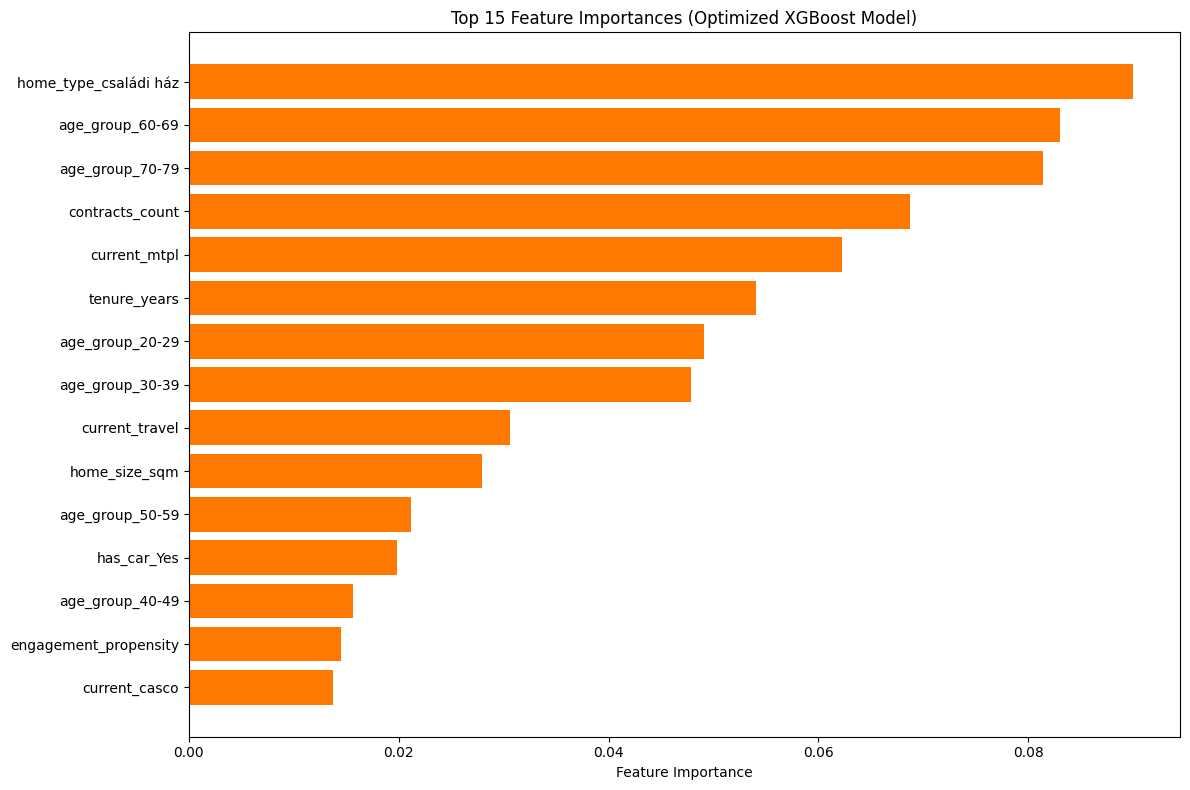

Plot saved: 02_optimized_feature_importance.png


In [8]:
# Get the best parameters from the study
best_params = study.best_params.copy()
best_params["objective"] = "binary:logistic"
best_params["eval_metric"] = "auc"
best_params["tree_method"] = "hist"
best_params["random_state"] = 42
best_params["early_stopping_rounds"] = 50

print(f"\nBest hyperparameters found:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

print(f"\nBest CV AUC from optimization: {study.best_value:.4f}")

# Train the final optimized model
final_optimized_model = xgb.XGBClassifier(**best_params)
final_optimized_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Evaluate the optimized model
optimized_pred = final_optimized_model.predict_proba(X_test)[:, 1]
optimized_auc = roc_auc_score(y_test, optimized_pred)
optimized_avg_prec = average_precision_score(y_test, optimized_pred)

print(f"\nFinal optimized model performance:")
print(f"  Test AUC: {optimized_auc:.4f}")
print(f"  Test PR-AUC: {optimized_avg_prec:.4f}")

# Compare with baseline model from previous cell
print(f"  Performance comparison:")
print(f"  Baseline AUC: {auc:.4f}")
print(f"  Optimized AUC: {optimized_auc:.4f}")
print(f"  Improvement: {(optimized_auc - auc)*100:.2f}% points")

# Feature importance from optimized model
feature_importance_opt = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_optimized_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 features (optimized model):")
display(feature_importance_opt.head(10))

# Calibrate the optimized model
cal_optimized_model = CalibratedClassifierCV(final_optimized_model, cv="prefit", method="sigmoid")
cal_optimized_model.fit(X_test, y_test)

# Score prospects with optimized model
prospects_optimized = netrisk_dataset_clean[netrisk_dataset_clean[TARGET] == 0].copy()

if ENCODING_METHOD == "lor":
    for col in FEATURES_CATEG:
        enc = target_encode_log_odds(train_df, col, TARGET)
        prospects_optimized[col + "_lor"] = prospects_optimized[col].map(enc).fillna(0)
        
elif ENCODING_METHOD == "onehot":
    # Apply same one-hot encoding to prospects
    for col in FEATURES_CATEG:
        if col not in train_df.columns:
            continue
        # Get categories from training set (excluding "No data")
        top_categories = train_df[col].value_counts().head(20).index.tolist()
        top_categories = [cat for cat in top_categories if cat != "No data"]
        for category in top_categories:
            feature_name = f"{col}_{category}"
            prospects_optimized[feature_name] = (prospects_optimized[col] == category).astype(int)

prospects_optimized["optimized_score"] = cal_optimized_model.predict_proba(prospects_optimized[FINAL_FEATURES])[:, 1]
prospects_optimized_ranked = prospects_optimized.sort_values("optimized_score", ascending=False)

# Feature importance visualization
fig = plt.figure(figsize=(12, 8))
top_features = feature_importance_opt.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances (Optimized XGBoost Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
save_plot(fig, "02_optimized_feature_importance")

## Modell értelmezése

A modell értelmezésére vizuális eszközöket és kimutatásokat is felhasználok. Elsőként az XGBoost alapértelmezett változó fontossági paraméterét vizsgálom, ugyanakkor az SHAP csomag eszköztára lehetőséget ad arra, hogy egy mintán tudjuk értelmezni, hogy a változóknak pontosan mekkora hatása volt egy predikciós valószínűség mértékében. Ez akár átlagolással, vagy egy konkrét eset lebontásával is megtörténhet.

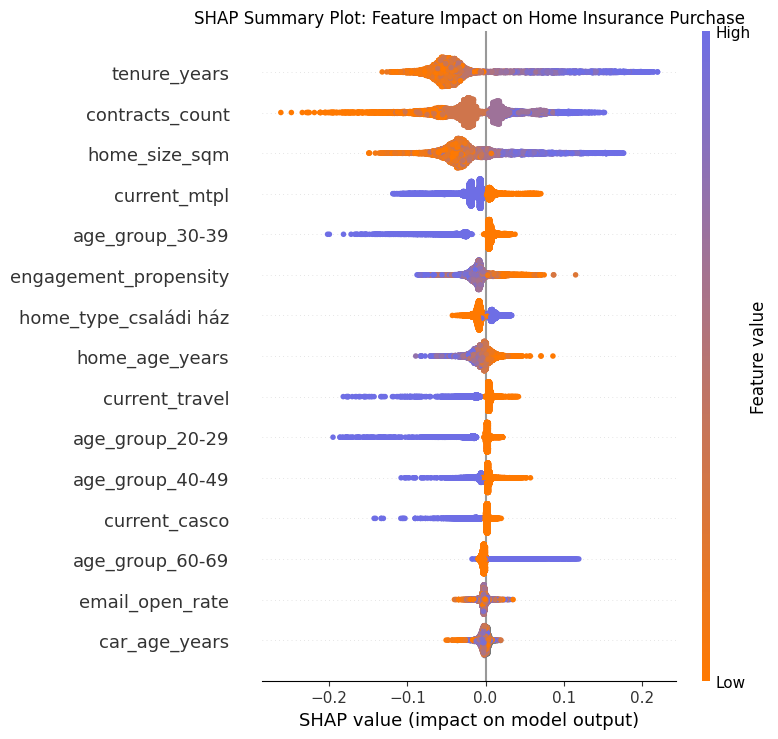

Plot saved: 03_shap_feature_impact.png


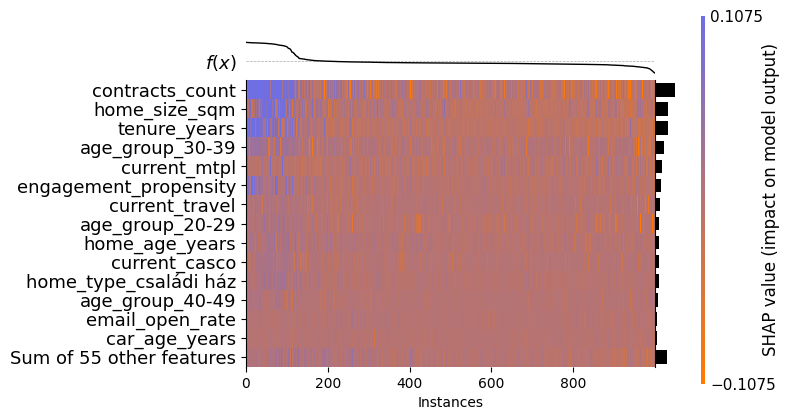

Plot saved: 03_shap_feature_heatmap.png


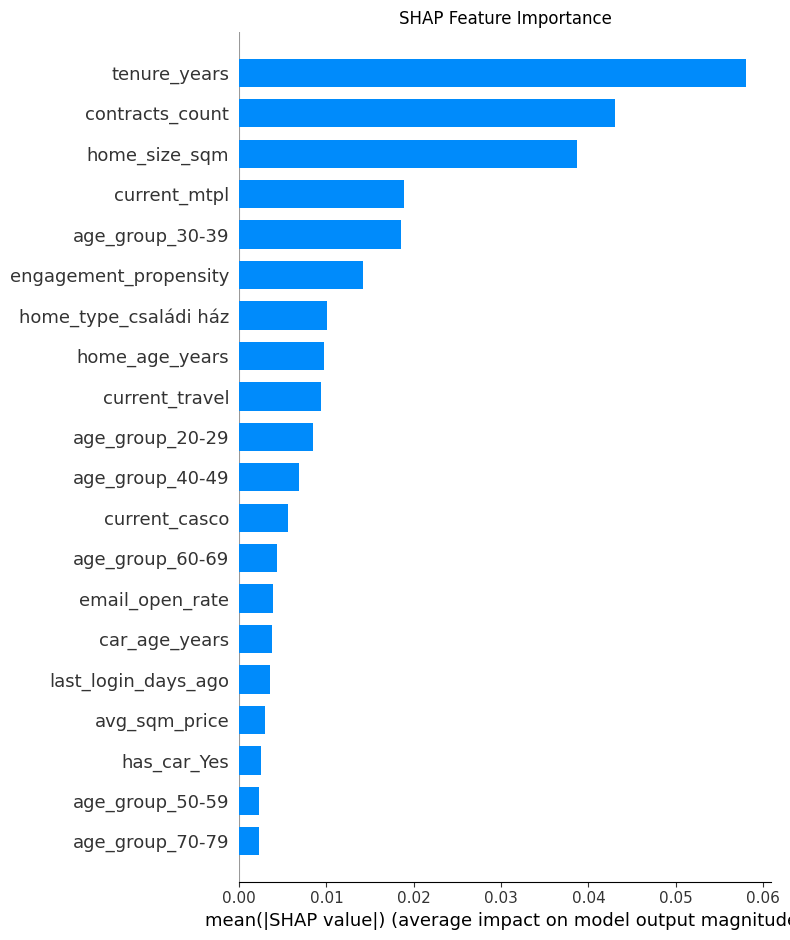

Plot saved: 03_shap_feature_importance.png


,feature,mean_abs_shap,mean_shap,std_shap,min_shap,max_shap
tenure_years,tenure_years,0.057991,-0.025670,0.061050,-0.132312,0.220199
contracts_count,contracts_count,0.043048,-0.015824,0.052649,-0.262054,0.152292
home_size_sqm,home_size_sqm,0.038720,-0.015794,0.044712,-0.149473,0.176820
current_mtpl,current_mtpl,0.018843,-0.013225,0.023043,-0.118764,0.070723
age_group_30-39,age_group_30-39,0.018593,-0.006965,0.028309,-0.202235,0.037774
engagement_propensity,engagement_propensity,0.014142,-0.006495,0.016664,-0.087720,0.115260
home_type_családi ház,home_type_családi ház,0.010101,-0.002635,0.011097,-0.042498,0.033492
home_age_years,home_age_years,0.009668,-0.004848,0.012586,-0.089388,0.086253
current_travel,current_travel,0.009409,-0.001206,0.016662,-0.182187,0.042103
age_group_20-29,age_group_20-29,0.008516,-0.003850,0.019116,-0.195296,0.022019


Customer ID: 87255
Predicted probability: 0.360

Predicted probability: 0.360


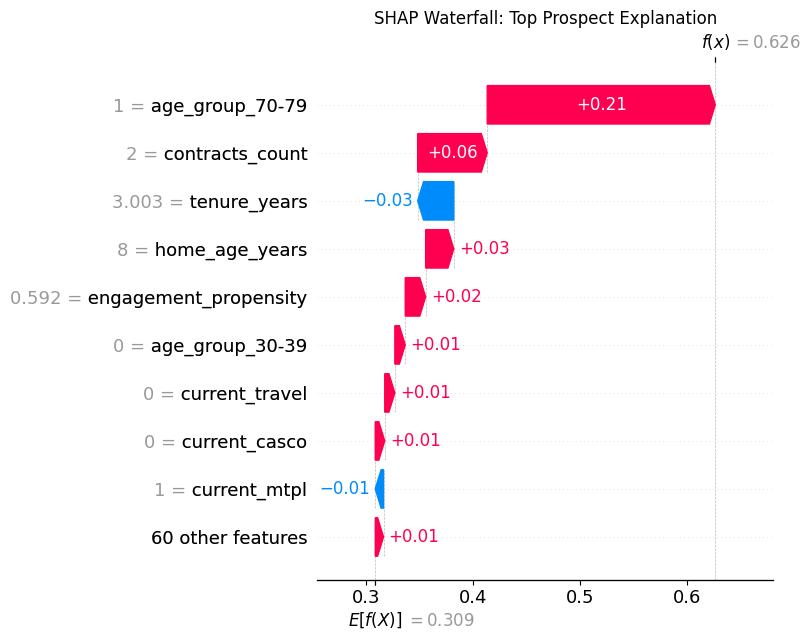

Plot saved: 03_shap_top_prospect_explanation.png


In [ ]:
explainer = shap.TreeExplainer(final_optimized_model)

sample_size = min(10000, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

shap_values = explainer.shap_values(X_test_sample)
explainer_heatmap = shap.Explainer(final_optimized_model, X_test)
shap_values_heatmap = explainer_heatmap(X_test[:1000])

# Generate colormap through matplotlib
newCmap = LinearSegmentedColormap.from_list("", [netrisk_colors['first'],netrisk_colors['second']])

# Summary plots
fig = plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="dot", show=False, cmap=newCmap, max_display = 15)
plt.title('SHAP Summary Plot: Feature Impact on Home Insurance Purchase')
plt.tight_layout()
plt.show()
save_plot(fig, "03_shap_feature_impact")


fig = plt.figure(figsize=(12, 8))
shap.plots.heatmap(shap_values_heatmap, max_display=15, show=False, cmap=newCmap, instance_order=shap_values_heatmap.sum(1))
plt.tight_layout()
plt.show()
save_plot(fig, "03_shap_feature_heatmap")

fig = plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False, cmap=newCmap)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()
save_plot(fig, "03_shap_feature_importance")

# SHAP statistics
shap_df = pd.DataFrame(shap_values, columns=X_test_sample.columns)
shap_summary = pd.DataFrame({
    'feature': shap_df.columns,
    'mean_abs_shap': shap_df.abs().mean(),
    'mean_shap': shap_df.mean(),
    'std_shap': shap_df.std(),
    'min_shap': shap_df.min(),
    'max_shap': shap_df.max()
}).sort_values('mean_abs_shap', ascending=False)

display(shap_summary.head(10))

# Top prospect explanation
top_prospect_idx = prospects_optimized_ranked.index[0]
prospect_features = prospects_optimized_ranked.loc[[top_prospect_idx], FINAL_FEATURES]

prospect_shap = explainer.shap_values(prospect_features)
expected_value = explainer.expected_value

print(f"Customer ID: {prospects_optimized_ranked.loc[top_prospect_idx, 'customer_id']}")
print(f"Predicted probability: {prospects_optimized_ranked.loc[top_prospect_idx, 'optimized_score']:.3f}")

fig = plt.figure(figsize=(12, 6))
shap.waterfall_plot(shap.Explanation(values=prospect_shap[0], 
                                   base_values=expected_value, 
                                   data=prospect_features.iloc[0].values,
                                   feature_names=prospect_features.columns.tolist()),
                   show=False)
plt.title('SHAP Waterfall: Top Prospect Explanation')
plt.tight_layout()
plt.show()
save_plot(fig, "03_shap_top_prospect_explanation")

# Business insights
pos_contributors = shap_summary[shap_summary['mean_shap'] > 0].head(3)
neg_contributors = shap_summary[shap_summary['mean_shap'] < 0].head(3)


## Marketing-fókuszú ügyfélcsoportok képzése

Azon ügyfeleket, akik a legmagasabb valószínűséget kapták a modellben, külön klaszterekre bontottam, hogy a targetálásuk még pontosabban történhessen. Ezáltal perszónákat alakíthatunk ki, akikre specifikus üzeneteket és csatornákat definiálhatunk.

Plot saved: 04_ecdf_optimized_score_distribution.png


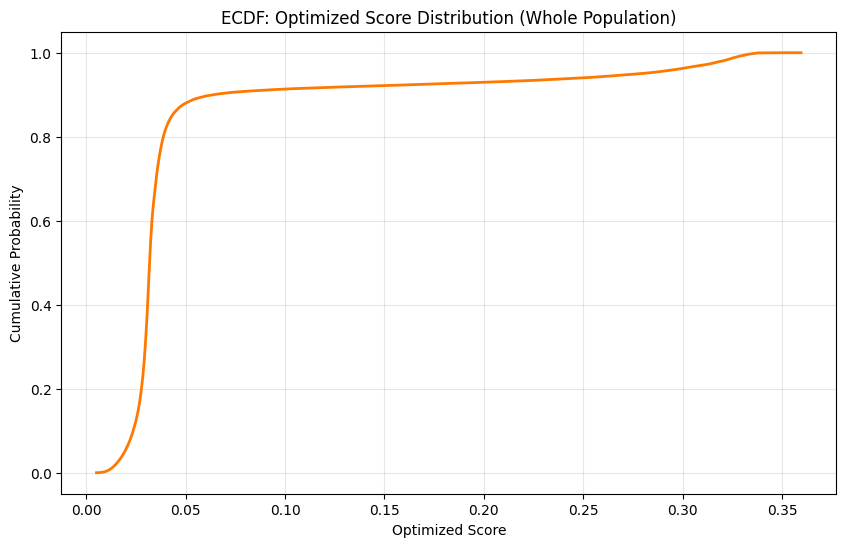

In [11]:
# Simple ECDF Plot for Optimized Score Distribution
all_scores = prospects_optimized_ranked['optimized_score']
sorted_scores = np.sort(all_scores)
ecdf_values = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)

fig = plt.figure(figsize=(10, 6))
plt.plot(sorted_scores, ecdf_values, color=netrisk_colors['first'], linewidth=2)
plt.xlabel('Optimized Score')
plt.ylabel('Cumulative Probability')
plt.title('ECDF: Optimized Score Distribution (Whole Population)')
plt.grid(True, alpha=0.3)
save_plot(fig, "04_ecdf_optimized_score_distribution")
plt.show()

Analyzing 28216 top prospects (score ≥ 0.050)
K=3: Silhouette Score = 0.129
K=3: Silhouette Score = 0.129
K=4: Silhouette Score = 0.120

Optimal K: 3
K=4: Silhouette Score = 0.120

Optimal K: 3


,optimized_score_mean,optimized_score_std,optimized_score_count,age_years_mean,tenure_years_mean,home_age_years_mean,home_size_sqm_mean,engagement_propensity_mean,home_purchased_last_12m_mean,contracts_count_mean
segment,,,,,,,,,,
0,0.22,0.10,5318,50.07,14.61,39.89,117.18,0.49,0.0,0.99
1,0.25,0.09,11088,51.52,20.10,46.35,96.49,0.41,0.0,2.29
2,0.16,0.10,11810,49.34,6.57,35.78,134.22,0.72,0.0,2.20


,segment,size,avg_score,avg_age,top_age_group,top_home_type,top_county,has_car_pct,current_contracts_pct
0,0,5318,0.222664,50.074254,40-49,családi ház,Pest,29.522377,0.226965
1,1,11088,0.252792,51.517478,40-49,családi ház,Pest,99.882756,1.467532
2,2,11810,0.163507,49.338046,40-49,családi ház,Pest,99.161727,1.701355


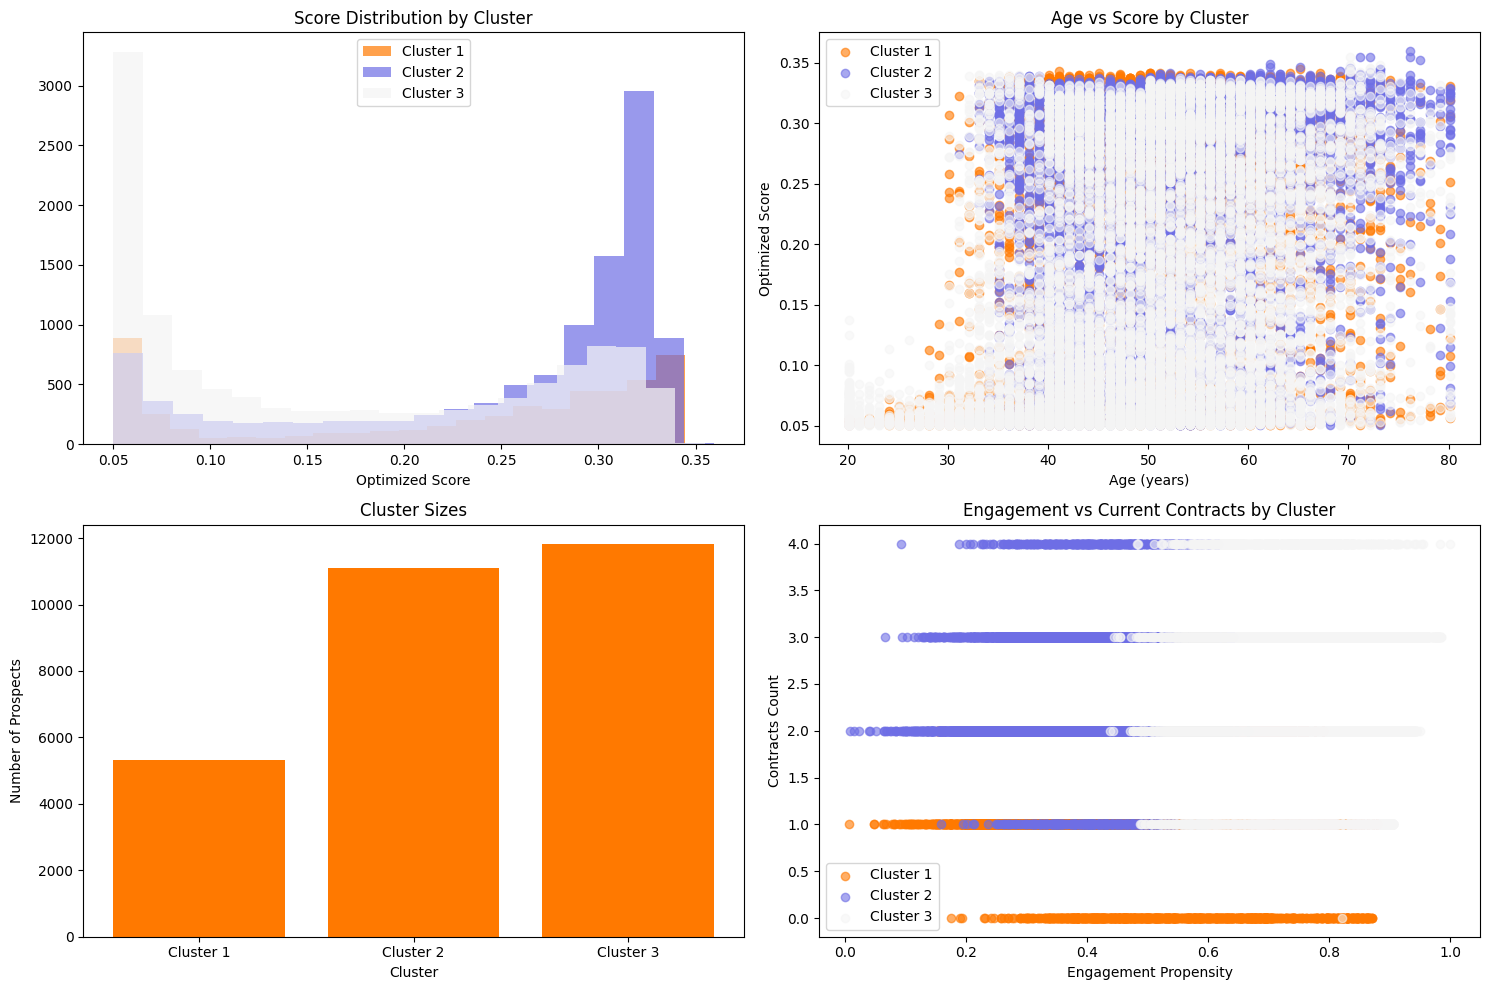

Plot saved: 05_top_prospects_segmentation.png


In [12]:
# Customer Clusteration for Top Prospects
top_prospect_threshold = 0.05

top_prospects = prospects_optimized_ranked[
    prospects_optimized_ranked['optimized_score'] >= top_prospect_threshold
].copy()

print(f"Analyzing {len(top_prospects)} top prospects (score ≥ {top_prospect_threshold:.3f})")

# Create segmentation features
segmentation_features = numeric_cols + ['optimized_score']

# Handle missing values for clustering
top_prospects_clean = top_prospects[segmentation_features].fillna(top_prospects[segmentation_features].median())

scaler = StandardScaler()
features_scaled = scaler.fit_transform(top_prospects_clean)

silhouette_scores = []
k_range = range(3,5)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features_scaled)
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K={k}: Silhouette Score = {silhouette_avg:.3f}")

# Use best k or default to 3 for practical marketing segments
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal K: {optimal_k}")

# Final clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
top_prospects['segment'] = kmeans_final.fit_predict(features_scaled)

segment_summary = top_prospects.groupby('segment').agg({
    'optimized_score': ['mean', 'std', 'count'],
    'age_years': 'mean',
    'tenure_years': 'mean', 
    'home_age_years': 'mean',
    'home_size_sqm': 'mean',
    'engagement_propensity': 'mean',
    'home_purchased_last_12m': 'mean',
    'contracts_count': 'mean'
}).round(2)

segment_summary.columns = ['_'.join(col).strip() for col in segment_summary.columns]
display(segment_summary)

# Categorical characteristics by segment
categorical_segment_analysis = []
for segment_id in sorted(top_prospects['segment'].unique()):
    segment_data = top_prospects[top_prospects['segment'] == segment_id]
    
    analysis = {
        'segment': segment_id,
        'size': len(segment_data),
        'avg_score': segment_data['optimized_score'].mean(),
        'avg_age': segment_data['age_years'].mean(),
        'top_age_group': segment_data['age_group'].mode().iloc[0] if not segment_data['age_group'].mode().empty else 'Unknown',
        'top_home_type': segment_data['home_type'].mode().iloc[0] if not segment_data['home_type'].mode().empty else 'Unknown',
        'top_county': segment_data['county_name'].mode().iloc[0] if not segment_data['county_name'].mode().empty else 'Unknown',
        'has_car_pct': (segment_data['has_car'] == 'Yes').mean() * 100,
        'current_contracts_pct': segment_data[['current_mtpl', 'current_casco', 'current_travel']].sum(axis=1).mean()
    }
    categorical_segment_analysis.append(analysis)

segment_profiles = pd.DataFrame(categorical_segment_analysis)
display(segment_profiles)
    
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Score distribution by segment
for segment_id in sorted(top_prospects['segment'].unique()):
    segment_data = top_prospects[top_prospects['segment'] == segment_id]
    axes[0,0].hist(segment_data['optimized_score'], alpha=0.7, 
                   label=f"Cluster {segment_id + 1}", bins=20)
axes[0,0].set_title('Score Distribution by Cluster')
axes[0,0].set_xlabel('Optimized Score')
axes[0,0].legend()

# 2. Age vs Score by segment
for segment_id in sorted(top_prospects['segment'].unique()):
    segment_data = top_prospects[top_prospects['segment'] == segment_id]
    axes[0,1].scatter(segment_data['age_years'], segment_data['optimized_score'], 
                      alpha=0.6, label=f"Cluster {segment_id + 1}")
axes[0,1].set_title('Age vs Score by Cluster')
axes[0,1].set_xlabel('Age (years)')
axes[0,1].set_ylabel('Optimized Score')
axes[0,1].legend()

# 3. Cluster sizes
segment_sizes = top_prospects['segment'].value_counts().sort_index()
axes[1,0].bar(range(len(segment_sizes)), segment_sizes.values)
axes[1,0].set_title('Cluster Sizes')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Number of Prospects')
axes[1,0].set_xticks(range(len(segment_sizes)))
axes[1,0].set_xticklabels([f"Cluster {i+1}" for i in segment_sizes.index])

# 4. Engagement vs Contracts by segment  
for segment_id in sorted(top_prospects['segment'].unique()):
    segment_data = top_prospects[top_prospects['segment'] == segment_id]
    axes[1,1].scatter(segment_data['engagement_propensity'], 
                      segment_data['contracts_count'], 
                      alpha=0.6, label=f"Cluster {segment_id + 1}")
axes[1,1].set_title('Engagement vs Current Contracts by Cluster')
axes[1,1].set_xlabel('Engagement Propensity')
axes[1,1].set_ylabel('Contracts Count')
axes[1,1].legend()

plt.tight_layout()
plt.show()
save_plot(fig, "05_top_prospects_segmentation")

segment,0,1,2
car_age_years,9.1691,8.9273,9.2036
home_size_sqm,117.1803,96.4885,134.2158
engagement_propensity,0.4892,0.4084,0.7152
last_login_days_ago,163.9682,166.7508,161.9765
email_open_rate,0.1340,0.0928,0.2366
tenure_years,14.6080,20.1011,6.5653
home_age_years,39.8949,46.3476,35.7848
avg_sqm_price,537.2080,581.9334,491.1202
contracts_count,0.9882,2.2942,2.1981
current_mtpl,0.0024,0.9897,0.9754


segment,0,1,2
car_age_years,9.1691,8.9273,9.2036
home_size_sqm,117.1803,96.4885,134.2158
engagement_propensity,0.4892,0.4084,0.7152
last_login_days_ago,163.9682,166.7508,161.9765
email_open_rate,0.1340,0.0928,0.2366
tenure_years,14.6080,20.1011,6.5653
home_age_years,39.8949,46.3476,35.7848
avg_sqm_price,537.2080,581.9334,491.1202
contracts_count,0.9882,2.2942,2.1981
current_mtpl,0.0024,0.9897,0.9754


Plot saved: 06_customer_segment_means_table.png and 06_customer_segment_means_table.pkl


segment,0,1,2
car_age_years,9.1691,8.9273,9.2036
home_size_sqm,117.1803,96.4885,134.2158
engagement_propensity,0.4892,0.4084,0.7152
last_login_days_ago,163.9682,166.7508,161.9765
email_open_rate,0.1340,0.0928,0.2366
tenure_years,14.6080,20.1011,6.5653
home_age_years,39.8949,46.3476,35.7848
avg_sqm_price,537.2080,581.9334,491.1202
contracts_count,0.9882,2.2942,2.1981
current_mtpl,0.0024,0.9897,0.9754


Plot saved: 06_customer_segment_means_table.png and 06_customer_segment_means_table.pkl


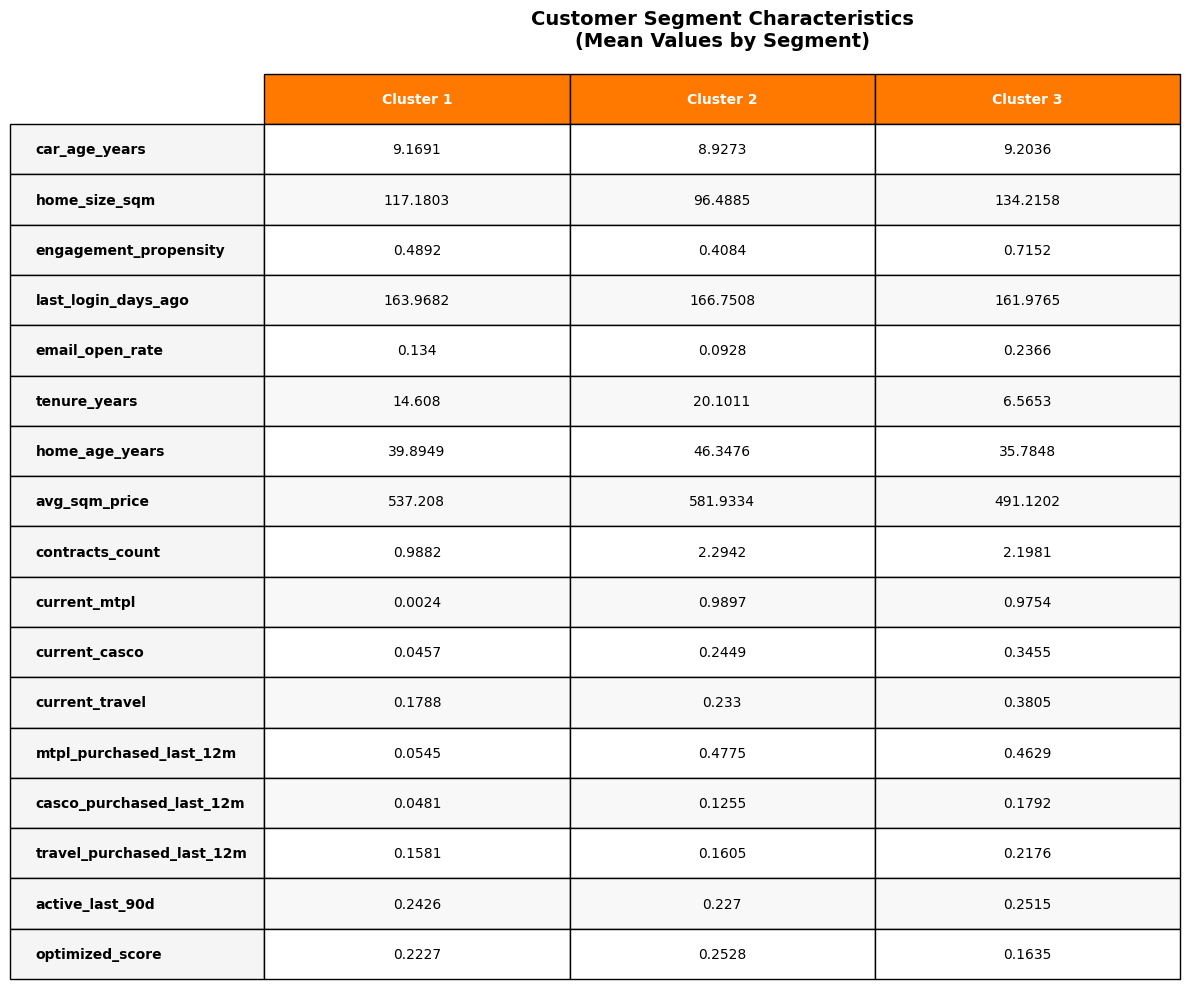

In [ ]:
# Create comprehensive means table for all clustering features
cluster_means = top_prospects.groupby('segment')[segmentation_features].mean().round(4)
cluster_means_transposed = cluster_means.T
display(cluster_means_transposed)

# Create a nice table visualization and save as PNG
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=cluster_means_transposed.values,
                rowLabels=cluster_means_transposed.index,
                colLabels=[f'Cluster {i+1}' for i in cluster_means_transposed.columns],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2.0)

# Header styling
for i in range(len(cluster_means_transposed.columns)):
    table[(0, i)].set_facecolor(netrisk_colors['first'])
    table[(0, i)].set_text_props(weight='bold', color='white')

# Row label styling
for i in range(1, len(cluster_means_transposed.index) + 1):
    table[(i, -1)].set_facecolor(netrisk_colors['third'])
    table[(i, -1)].set_text_props(weight='bold')

# Alternate row colors for better readability
for i in range(1, len(cluster_means_transposed.index) + 1):
    for j in range(len(cluster_means_transposed.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f8f8f8')

plt.title('Customer Segment Characteristics\n(Mean Values by Segment)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
save_plot(fig, "06_customer_segment_means_table")
plt.show()